# Libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat

reference_date = pd.to_datetime("2023-08-01 00:00:00")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [0]:
#TABLE CREATED USING QUERY ON ORIGINAL DATABASE
#df_spark = spark.table("workspace.default.user_agg_tab")

#TABLE CREATED USING QUERY ON SESSION TABLE
df_spark = spark.table("workspace.default.usertab_from_sessiontab_spark") #TABLE SAVED AS "users_RawTab.csv"
df = df_spark.toPandas()

#replace age_bin coming from the delta table as dictionaries with actual pd.cut intervals
bins_range = [df.age_in_2023.min(), 20, 30, 40, 50, 60, 70, 80, 90]
df['age_bin'] = pd.cut(df.age_in_2023, bins=bins_range, right=False)

In [0]:
df.age_bin.value_counts()

age_bin
[40, 50)    2124
[30, 40)    1508
[50, 60)    1038
[20, 30)     697
[17, 20)     307
[60, 70)     225
[70, 80)      87
[80, 90)      12
Name: count, dtype: int64

# Data Preprocessing

In [0]:
df.isnull().sum()#/df.shape[0]*100

user_id                                     0
nr_sessions                                 0
date_last_booking_travelled               564
page_clicks_tot                             0
page_clicks_avg                             0
flights_taken                               0
hotels_stayed                               0
nr_booked_and_travelled                     0
nr_booked_but_cancelled                     0
nr_cancellation_session                     0
nr_no_booking                               0
flight_taken_discount_avg                4052
flight_taken_discount_nr                    0
hotel_stayed_discount_avg                4199
hotel_stayed_discount_nr                    0
hotel_and_flight_discount_nr                0
flight_taken_price_avg                    966
hotel_stayed_room_price_per_night_avg     674
hotel_stayed_nights_avg                   674
nr_airlines_taken                           0
distance_km_tot                           966
distance_km_avg                   

In [0]:
#what are those NULL user spend tot?
df.loc[(df.flights_taken == 0) & (df.hotels_stayed == 0), 'user_spend_tot'].shape
#they belong to those users without both flights taken and hotel visited!!

(564,)

In [0]:
#what about those NULL hotel nights?
df.loc[df.hotel_stayed_nights_avg.isnull(), "hotels_stayed"].value_counts()
#they are all users with no hotels stayed

hotels_stayed
0    674
Name: count, dtype: int64

I will add two binary features, "has_flights" and "has_hotels", indicating whether a user has taken at least one flight or stayed in a hotel.
These flags make the “no activity” information explicit, allowing you to replace NaN values with 0 in the related features (average discounts, average prices, average distances, average nights, etc.) without semantic ambiguity.
In this setup, a value of 0 does not represent a real measured quantity (e.g. zero price), but rather a not-applicable value, while the binary flags help the clustering algorithm interpret the data correctly after scaling and distance computation.


In [0]:
#I drop "date_last_booking_travelled" because it is not useful for the analysis and it contains NULL values
#I inserted it in the user tab in order to calculate the RFM score...not needed here then
#I will also drop "age_bin" since it is not usefulhere, we have already "age_in_2023"
#I will also drop "birthdate" because dates are not good for unsupervised algorithm; better to use number related to dates, like "age" in this case
df_woNaN = df.drop(columns=['date_last_booking_travelled', 'age_bin', 'birthdate'])

In [0]:
#I will replace sign-up date with "time_since_signup"
df_woNaN['time_since_signup'] = (reference_date - df_woNaN['sign_up_date']).dt.days
df_woNaN = df_woNaN.drop(columns=['sign_up_date'])

In [0]:
df_woNaN['time_since_signup'].describe()

count    5998.000000
mean      192.898466
std        35.360982
min        75.000000
25%       177.000000
50%       194.000000
75%       205.000000
max       740.000000
Name: time_since_signup, dtype: float64

In [0]:
#Flag features (check explaination above why I create them)
df_woNaN['has_flights'] = df_woNaN.apply(lambda row: 1 if row['flights_taken'] > 0 else 0, axis=1)
df_woNaN['has_hotels'] = df_woNaN.apply(lambda row: 1 if row['hotels_stayed'] > 0 else 0, axis=1)

In [0]:
df.shape

(5998, 43)

In [0]:
df_woNaN.shape

(5998, 42)

In [0]:
#replace missing values with 0
numer_col = df_woNaN.select_dtypes(include='number').columns
df_woNaN[numer_col] = df_woNaN[numer_col].fillna(0)
#I had to go this way because, for some reason, fillna() was not working when directly applied to the dataframe

In [0]:
df_woNaN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   user_id                                5998 non-null   int64  
 1   nr_sessions                            5998 non-null   int64  
 2   page_clicks_tot                        5998 non-null   int64  
 3   page_clicks_avg                        5998 non-null   float64
 4   flights_taken                          5998 non-null   int64  
 5   hotels_stayed                          5998 non-null   int64  
 6   nr_booked_and_travelled                5998 non-null   int64  
 7   nr_booked_but_cancelled                5998 non-null   int64  
 8   nr_cancellation_session                5998 non-null   int64  
 9   nr_no_booking                          5998 non-null   int64  
 10  flight_taken_discount_avg              5998 non-null   float64
 11  flig

## Categorical Data Encoding

In [0]:
df_woNaN.select_dtypes(exclude=['number', 'datetime64']).columns

Index(['gender', 'married', 'has_children', 'home_country', 'home_city',
       'home_airport'],
      dtype='object')

In [0]:
df_woNaN.select_dtypes(include=['bool']).columns

Index(['married', 'has_children'], dtype='object')

converting boolean values in integer

In [0]:
bool_col = df_woNaN.select_dtypes(include=['bool']).columns
df_woNaN[bool_col] = df_woNaN[bool_col].astype(int)

gender column

In [0]:
df_woNaN.gender.value_counts()

gender
F    5292
M     695
O      11
Name: count, dtype: int64

In [0]:
#df_woNaN['gender'] = df_woNaN['gender'].replace({'F': 0, 'M': 1, 'O': 2})

In [0]:
df_woNaN.gender.value_counts()

gender
F    5292
M     695
O      11
Name: count, dtype: int64

home_city
new york          680
los angeles       325
toronto           225
chicago           195
houston           185
                 ... 
grand rapids       14
modesto            14
spokane            13
salt lake city     13
newport news       13
Name: count, Length: 105, dtype: int64

In [0]:
#how many different home_airport we have?
df_woNaN.home_airport.value_counts()
#too many

home_airport
LGA    362
LAX    325
JFK    318
DAL    117
YYC    101
      ... 
SKA      6
POB      6
EDF      5
GEG      4
SFF      3
Name: count, Length: 159, dtype: int64

home_city and home_airport have many categories, and there is no natural way to convert them into numbers that have a meaningful distance.
Since KMeans relies on numeric distances, encoding cities/airports would introduce artificial patterns and noise rather than real behavioral information.
For this reason, it makes more sense to drop these 2 columns and possibly use it only later to interpret the clusters.

In [0]:
df_woNaN = df_woNaN.drop(['home_city', 'home_airport'], axis=1)

In [0]:
df_woNaN.home_country.value_counts()

home_country
usa       4991
canada    1007
Name: count, dtype: int64

encoding gender and home_country

In [0]:
#Step 1
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# Step 2
encoder.fit(df_woNaN[['gender', 'home_country']])	

# Step 3
encoded = encoder.transform(df_woNaN[['gender', 'home_country']]) 
#array che va poi trasformato in dataframe e concatenato all’originale

# Step 4
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['gender', 'home_country']))

In [0]:
df_woNaN = pd.concat([df_woNaN, encoded_df], axis=1)
df_woNaN = df_woNaN.drop(['gender', 'home_country'], axis=1)
df_woNaN.head()

,user_id,nr_sessions,page_clicks_tot,page_clicks_avg,flights_taken,hotels_stayed,nr_booked_and_travelled,nr_booked_but_cancelled,nr_cancellation_session,nr_no_booking,flight_taken_discount_avg,flight_taken_discount_nr,hotel_stayed_discount_avg,hotel_stayed_discount_nr,hotel_and_flight_discount_nr,flight_taken_price_avg,hotel_stayed_room_price_per_night_avg,hotel_stayed_nights_avg,nr_airlines_taken,distance_km_tot,distance_km_avg,duration_tot,duration_avg,married,has_children,home_airport_lat,home_airport_lon,age_in_2023,user_spend_tot,user_spend_avg,booking_window_days_avg,booking_window_days_min,booking_window_days_max,family_travelled_trip_nr,non_family_travelled_trip_nr,time_since_signup,has_flights,has_hotels,gender_F,gender_M,gender_O,home_country_canada,home_country_usa
0,23557,8,82,10.250,0,2,2,0,0,6,0.0,0,0.25,1,0,0.000,177.0,10.0,0,0.000000,0.000000,20.0,10.0,1,0,40.777,-73.872,65,3802.00,1901.000,12.815833,10.932535,14.699132,0,2,740,0,1,1.0,0.0,0.0,0.0,1.0
1,94883,8,73,9.125,4,2,2,0,0,6,0.0,0,0.00,0,0,432.045,90.0,1.0,2,2907.336271,1453.668135,3.0,1.5,1,0,39.297,-94.714,51,1094.09,547.045,7.151759,5.530370,8.773148,0,2,540,1,1,1.0,0.0,0.0,0.0,1.0
2,101486,8,131,16.375,2,2,2,0,0,6,0.0,0,0.00,0,0,189.910,198.5,4.5,1,965.341901,965.341901,9.0,4.5,1,1,47.138,-122.476,51,2641.91,1320.955,7.837760,6.635683,9.039838,1,1,530,1,1,1.0,0.0,0.0,0.0,1.0
3,101961,8,126,15.750,10,5,5,0,0,3,0.1,1,0.00,0,0,248.532,136.0,4.4,5,6608.430041,1321.686008,24.0,4.8,1,0,42.364,-71.005,43,4040.66,808.132,6.257370,3.542292,10.645613,0,5,530,1,1,1.0,0.0,0.0,0.0,1.0
4,106907,8,240,30.000,0,0,0,1,1,6,0.0,0,0.00,0,0,0.000,0.0,0.0,0,0.000000,0.000000,0.0,0.0,1,1,25.862,-80.897,45,0.00,0.000,0.000000,0.000000,0.000000,0,0,523,0,0,1.0,0.0,0.0,0.0,1.0


## Feature scaling

In [0]:
scaler = StandardScaler()

scaler.fit(df_woNaN.drop(['user_id', 'married', 'has_children', 'has_flights', 'has_hotels', 'gender_F' , 'gender_M', 'gender_O', 'home_country_canada', 'home_country_usa'], axis=1))

col_scaled = scaler.transform(df_woNaN.drop(['user_id', 'married', 'has_children', 'has_flights', 'has_hotels', 'gender_F' , 'gender_M', 'gender_O', 'home_country_canada', 'home_country_usa'], axis=1)
)

In [0]:
col_names = df_woNaN.drop(['user_id', 'married', 'has_children', 'has_flights', 'has_hotels', 'gender_F' , 'gender_M', 'gender_O', 'home_country_canada', 'home_country_usa'], axis=1).columns

df_woNaN[col_names] = pd.DataFrame(col_scaled, columns=col_names)

In [0]:
df_woNaN.head()

,user_id,nr_sessions,page_clicks_tot,page_clicks_avg,flights_taken,hotels_stayed,nr_booked_and_travelled,nr_booked_but_cancelled,nr_cancellation_session,nr_no_booking,flight_taken_discount_avg,flight_taken_discount_nr,hotel_stayed_discount_avg,hotel_stayed_discount_nr,hotel_and_flight_discount_nr,flight_taken_price_avg,hotel_stayed_room_price_per_night_avg,hotel_stayed_nights_avg,nr_airlines_taken,distance_km_tot,distance_km_avg,duration_tot,duration_avg,married,has_children,home_airport_lat,home_airport_lon,age_in_2023,user_spend_tot,user_spend_avg,booking_window_days_avg,booking_window_days_min,booking_window_days_max,family_travelled_trip_nr,non_family_travelled_trip_nr,time_since_signup,has_flights,has_hotels,gender_F,gender_M,gender_O,home_country_canada,home_country_usa
0,23557,-0.371934,-0.856811,-0.839620,-1.431753,-0.204648,-0.368595,-0.325912,-0.325912,0.360060,-0.56701,-0.634552,3.642795,1.087422,-0.252319,-0.886501,0.190577,2.090448,-1.469045,-1.181226,-1.308652,0.939332,1.959193,1,0,0.377660,1.123663,1.966422,0.269756,0.800268,0.087470,0.233187,-0.053460,-0.324429,-0.284924,15.473189,0,1,1.0,0.0,0.0,0.0,1.0
1,94883,-0.371934,-0.982355,-0.969388,-0.085092,-0.204648,-0.368595,-0.325912,-0.325912,0.360060,-0.56701,-0.634552,-0.557831,-0.597506,-0.252319,0.096438,-0.697922,-0.981779,0.010856,-0.444870,-0.270160,-1.019438,-0.976191,1,0,0.138518,-0.029758,0.804483,-0.726807,-0.575150,-0.153655,-0.067363,-0.183986,-0.324429,-0.284924,9.816766,1,1,1.0,0.0,0.0,0.0,1.0
2,101486,-0.371934,-0.173291,-0.133102,-0.758423,-0.204648,-0.368595,-0.325912,-0.325912,0.360060,-0.56701,-0.634552,-0.557831,-0.597506,-0.252319,-0.454440,0.410149,0.212976,-0.729095,-0.936729,-0.619018,-0.328107,0.059827,1,1,1.405488,-1.566140,0.804483,-0.157179,0.211028,-0.124451,-0.005869,-0.178112,2.202748,-0.942222,9.533944,1,1,1.0,0.0,0.0,0.0,1.0
3,101961,-0.371934,-0.243038,-0.205196,1.934898,1.867628,1.599504,-0.325912,-0.325912,-1.502236,0.67074,1.028202,-0.557831,-0.597506,-0.252319,-0.321070,-0.228141,0.178840,2.230708,0.492524,-0.364448,1.400219,0.163428,1,0,0.634092,1.282326,0.140517,0.357588,-0.309924,-0.191729,-0.177970,-0.142743,-0.324429,1.686970,9.533944,1,1,1.0,0.0,0.0,0.0,1.0
4,106907,-0.371934,1.347193,1.438538,-1.431753,-1.586165,-1.680660,2.937559,2.937559,0.360060,-0.56701,-0.634552,-0.557831,-0.597506,-0.252319,-0.886501,-1.617059,-1.323138,-1.469045,-1.181226,-1.308652,-1.365103,-1.494201,1,1,-2.032346,0.734891,0.306508,-1.129453,-1.130867,-0.458111,-0.375045,-0.377223,-0.324429,-1.599520,9.335970,0,0,1.0,0.0,0.0,0.0,1.0


#KMeans

In [0]:
df_woNaN.drop(columns='user_id').columns

Index(['nr_sessions', 'page_clicks_tot', 'page_clicks_avg', 'flights_taken',
       'hotels_stayed', 'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'flight_taken_discount_nr', 'hotel_stayed_discount_avg',
       'hotel_stayed_discount_nr', 'hotel_and_flight_discount_nr',
       'flight_taken_price_avg', 'hotel_stayed_room_price_per_night_avg',
       'hotel_stayed_nights_avg', 'nr_airlines_taken', 'distance_km_tot',
       'distance_km_avg', 'duration_tot', 'duration_avg', 'married',
       'has_children', 'home_airport_lat', 'home_airport_lon', 'age_in_2023',
       'user_spend_tot', 'user_spend_avg', 'booking_window_days_avg',
       'booking_window_days_min', 'booking_window_days_max',
       'family_travelled_trip_nr', 'non_family_travelled_trip_nr',
       'time_since_signup', 'has_flights', 'has_hotels', 'gender_F',
       'gender_M', 'gender_O', 'home_country_canada', 'home_country_usa'

In [0]:
inertias = []
K_range = range(1, 12)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=50, random_state=30)
    km.fit(df_woNaN.drop(columns='user_id'))
    inertias.append(km.inertia_)

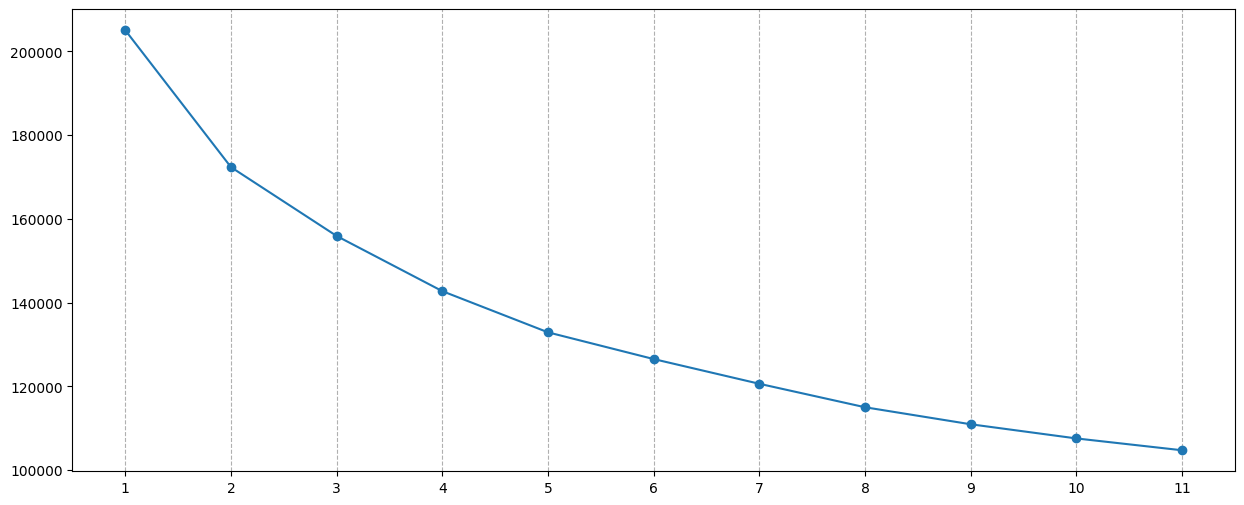

In [0]:
plt.figure(figsize=(15, 6))
plt.plot(K_range, inertias, marker="o")
plt.xticks(K_range)
plt.grid(axis='x', linestyle='--')
plt.show()

In [0]:
df_woNaN.columns

Index(['user_id', 'nr_sessions', 'page_clicks_tot', 'page_clicks_avg',
       'flights_taken', 'hotels_stayed', 'nr_booked_and_travelled',
       'nr_booked_but_cancelled', 'nr_cancellation_session', 'nr_no_booking',
       'flight_taken_discount_avg', 'flight_taken_discount_nr',
       'hotel_stayed_discount_avg', 'hotel_stayed_discount_nr',
       'hotel_and_flight_discount_nr', 'flight_taken_price_avg',
       'hotel_stayed_room_price_per_night_avg', 'hotel_stayed_nights_avg',
       'nr_airlines_taken', 'distance_km_tot', 'distance_km_avg',
       'duration_tot', 'duration_avg', 'married', 'has_children',
       'home_airport_lat', 'home_airport_lon', 'age_in_2023', 'user_spend_tot',
       'user_spend_avg', 'booking_window_days_avg', 'booking_window_days_min',
       'booking_window_days_max', 'family_travelled_trip_nr',
       'non_family_travelled_trip_nr', 'time_since_signup', 'has_flights',
       'has_hotels', 'gender_F', 'gender_M', 'gender_O', 'home_country_canada',
       

In [0]:
kmeans = KMeans(n_clusters=3, n_init=100, random_state=30)
kmeans_k3_segments = kmeans.fit_predict(df_woNaN.drop(columns='user_id'))

In [0]:
kmeans = KMeans(n_clusters=4, n_init=100, random_state=30)
kmeans_k4_segments = kmeans.fit_predict(df_woNaN.drop(columns='user_id'))

In [0]:
kmeans = KMeans(n_clusters=5, n_init=100, random_state=30)
kmeans_k5_segments = kmeans.fit_predict(df_woNaN.drop(columns='user_id'))

In [0]:
kmeans_segments = pd.DataFrame({
    'kmeans_k3_segments': kmeans_k3_segments,
    'kmeans_k4_segments': kmeans_k4_segments,
    'kmeans_k5_segments': kmeans_k5_segments
})
kmeans_segments.head()

,kmeans_k3_segments,kmeans_k4_segments,kmeans_k5_segments
0,0,0,0
1,0,0,0
2,0,0,0
3,1,2,4
4,2,3,1


## Silhouette scores

In [0]:
silhouette_k3 = silhouette_score(df_woNaN.drop(columns='user_id'), kmeans_k3_segments)
silhouette_k3

np.float64(0.17233970804438895)

In [0]:
silhouette_k4 = silhouette_score(df_woNaN.drop(columns='user_id'), kmeans_k4_segments)
silhouette_k4

np.float64(0.17752668042972428)

In [0]:
silhouette_k5 = silhouette_score(df_woNaN.drop(columns='user_id'), kmeans_k5_segments)
silhouette_k5

np.float64(0.13266536436437246)

CONCLUSION: Silhouette score is very bad, so KMeans segmentation will not be used

#KMeans 2

In [0]:
df_trav_user_types = df_woNaN[['flights_taken',
       'hotels_stayed','flight_taken_discount_avg',
       'hotel_stayed_discount_avg', 'flight_taken_price_avg',
       'hotel_stayed_room_price_per_night_avg', 'hotel_stayed_nights_avg',
       'nr_airlines_taken', 'distance_km_tot', 'distance_km_avg',
       'duration_tot', 'duration_avg', 'married', 'has_children', 'age_in_2023', 'time_since_signup', 'has_flights', 'has_hotels',
       'gender_F', 'gender_M', 'gender_O', 'home_country_canada',
       'home_country_usa']]

In [0]:
inertias = []
K_range = range(1, 12)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=50, random_state=30)
    km.fit(df_trav_user_types)
    inertias.append(km.inertia_)

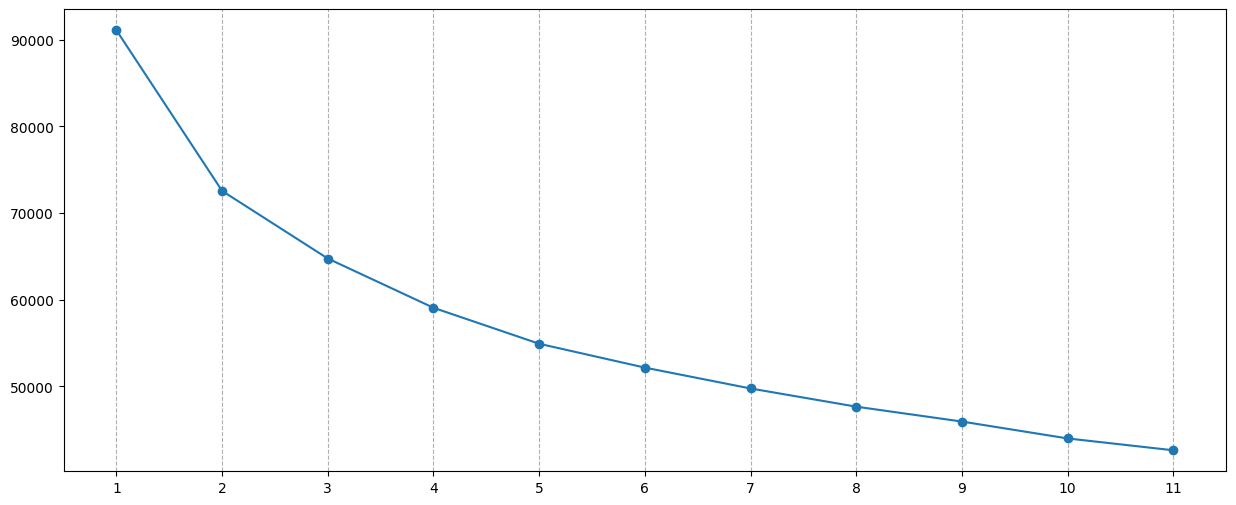

In [0]:
plt.figure(figsize=(15, 6))
plt.plot(K_range, inertias, marker="o")
plt.xticks(K_range)
plt.grid(axis='x', linestyle='--')
plt.show()

# Hierarchical Clustering

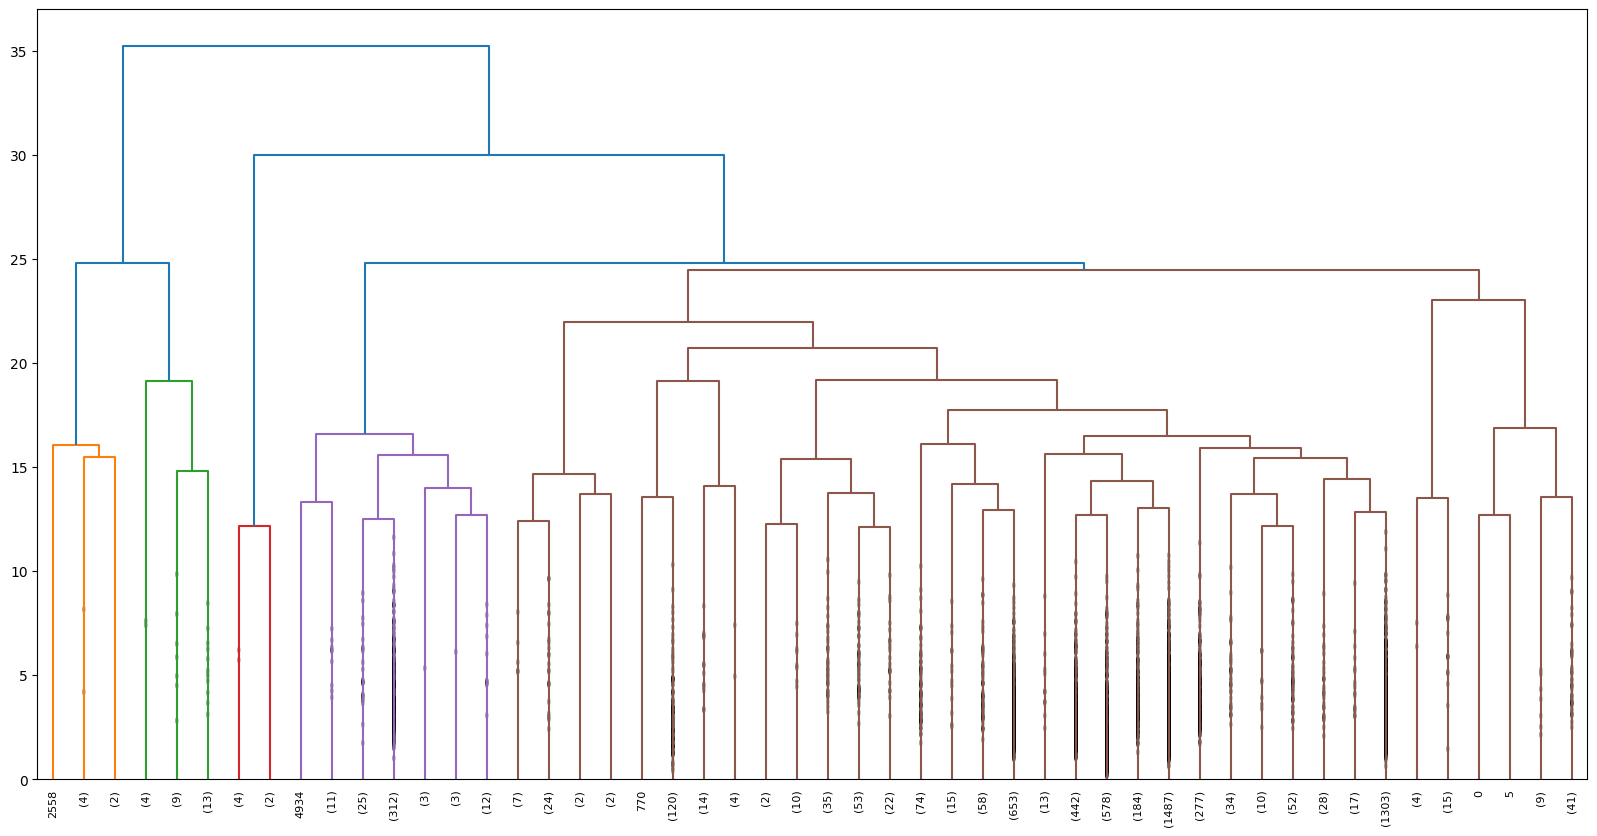

In [0]:
# Compute linkage matrix
Z = linkage(df_woNaN.drop(columns='user_id'), method="complete")

# Plot dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, truncate_mode="lastp", p=50, show_contracted=True)
plt.show()

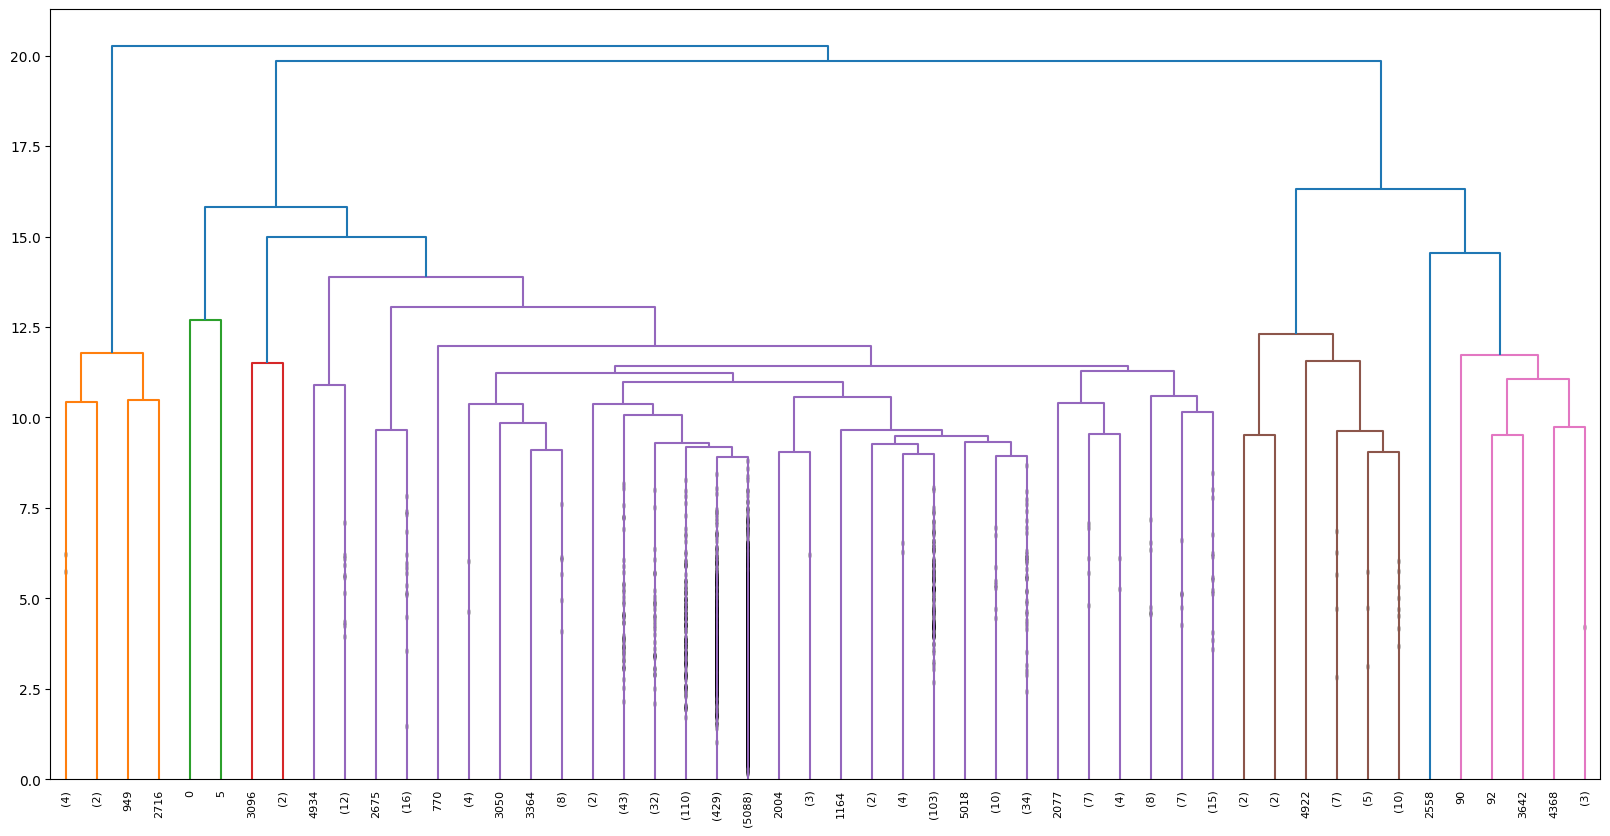

In [0]:
# Compute linkage matrix
Z = linkage(df_woNaN.drop(columns='user_id'), method="average")

# Plot dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, truncate_mode="lastp", p=50, show_contracted=True)
plt.show()

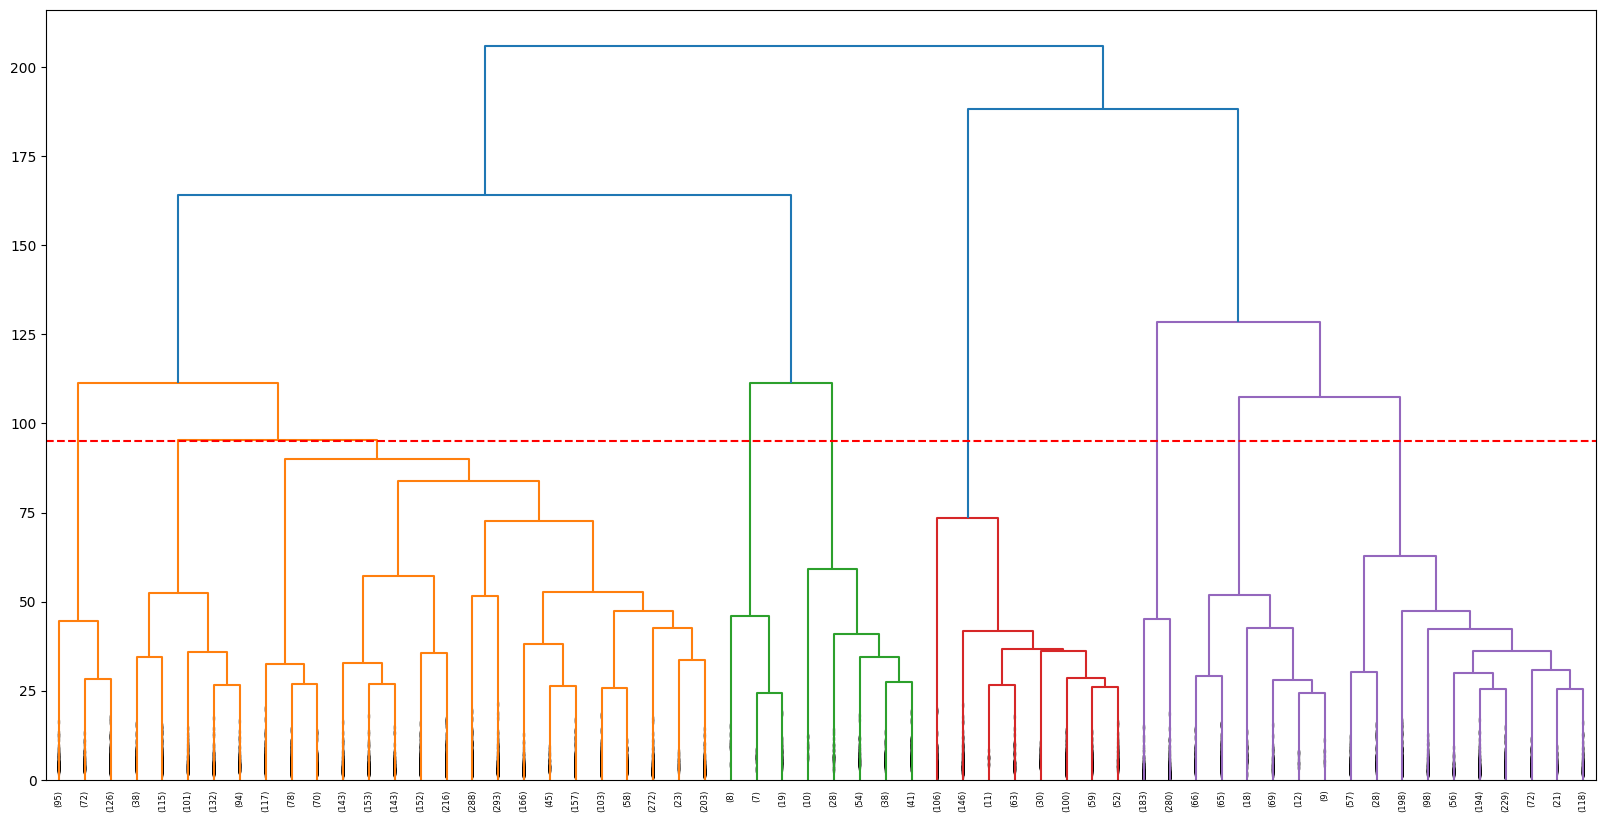

In [0]:
# Compute linkage matrix
Z = linkage(df_woNaN.drop(columns='user_id'), method="ward")

# Plot dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, truncate_mode="lastp", p=60, show_contracted=True)
plt.axhline(y=95, color='r', linestyle='--')
plt.show()

In [0]:
hc = AgglomerativeClustering(n_clusters=6, linkage="ward")
labels = hc.fit_predict(df_woNaN.drop(columns='user_id'))
hc_segments = pd.DataFrame({
    'hc_segments': labels
})

In [0]:
hc_segments.head()

,hc_segments
0,1
1,1
2,1
3,1
4,2


## Silhouette Score

In [0]:
silhouette_hc6 = silhouette_score(df_woNaN.drop(columns='user_id'), labels)
silhouette_hc6

np.float64(0.11219027473631099)

CONCLUSION: Silhouette score is very low for hierarchical clustering too, so it will no be used to cluster the users

#Combine segment columns to df

In [0]:
df['time_since_signup'] = (reference_date - df['sign_up_date']).dt.days
df['has_flights'] = df_woNaN['has_flights']
df['has_hotels'] = df_woNaN['has_hotels']

In [0]:
df = pd.concat([df, kmeans_segments, hc_segments], axis =1)
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'flight_taken_discount_nr', 'hotel_stayed_discount_avg',
       'hotel_stayed_discount_nr', 'hotel_and_flight_discount_nr',
       'flight_taken_price_avg', 'hotel_stayed_room_price_per_night_avg',
       'hotel_stayed_nights_avg', 'nr_airlines_taken', 'distance_km_tot',
       'distance_km_avg', 'duration_tot', 'duration_avg', 'birthdate',
       'gender', 'married', 'has_children', 'home_country', 'home_city',
       'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'age_in_2023', 'age_bin', 'user_spend_tot', 'user_spend_avg',
       'booking_window_days_avg', 'booking_window_days_min',
       'booking_window_days_max', 'family_travelled_trip_nr',
       'non_family_tra

In [0]:
df_woNaN.has_hotels.value_counts()

has_hotels
1    5324
0     674
Name: count, dtype: int64